<a href="https://colab.research.google.com/github/RafaelSdeSouza/DataScience/blob/main/MLNN/PAM_CNN_ComputerVision_LEGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify images.


### Import TensorFlow

In [ ]:
#pip install visualkeras

In [ ]:
import tensorflow as tf
import os
import PIL
from tensorflow.keras import datasets, layers, models
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import numpy as np
from keras import layers, models, regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_directory = "/content/drive/MyDrive/PAM_MachineLearning/Lego/"  # Replace with the directory name containing your dataset
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")
image_size = (128, 128)  # Adjust this tuple according to your requirements

## *Load* images and labels

In [ ]:
# Function to load and preprocess data
def load_and_preprocess_data(directory, image_size):
    data, labels = [], []

    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)
        label = category

        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
            data.append(image_array)
            labels.append(label)

    return np.array(data), labels

def augment_data(images, labels, class_name, num_required, augmenter):
    class_images = [img for img, lbl in zip(images, labels) if lbl == class_name]
    augmented_images = []

    i = 0
    while len(augmented_images) < num_required:
        img = np.expand_dims(class_images[i % len(class_images)], axis=0)
        augmented = next(augmenter.flow(img, batch_size=1))
        augmented_images.append(np.squeeze(augmented))
        i += 1

    return np.array(augmented_images), [class_name] * num_required


def augment_and_combine(images, labels, class_name, num_required, augmenter):
    additional_images, additional_labels = augment_data(images, labels, class_name, num_required, augmenter)
    combined_images = np.concatenate([images, additional_images])
    combined_labels = labels.extend(additional_labels)  # Extend the original list
    return combined_images, labels

# Unified augmentation settings
data_augmentation = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Load data
train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
test_images, test_labels = load_and_preprocess_data(test_directory, image_size)

# Call for each class
train_images, train_labels = augment_and_combine(train_images, train_labels, "jurassic-world", 21, data_augmentation)
train_images, train_labels = augment_and_combine(train_images, train_labels, "harry-potter", 22, data_augmentation)

train_labels = np.array(train_labels)
train_images = np.array(train_images)

# Load Train and Test data
#train_images, train_labels = load_and_preprocess_data(train_directory, image_size)
#test_images, test_labels = load_and_preprocess_data(test_directory, image_size)

In [ ]:
# Print the shape of the data and labels arrays
print("Data shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Data shape: (136, 128, 128, 3)
Labels shape: (136,)


In [ ]:
# Distribution of Data points among classes
import pandas as pd
freq = pd.Series(train_labels).value_counts()
print(freq)

jurassic-world    35
marvel            35
harry-potter      35
star-wars         31
dtype: int64


In [ ]:
class_names = unique_labels = np.unique(train_labels)
print(class_names)

['harry-potter' 'jurassic-world' 'marvel' 'star-wars']


In [ ]:
class_to_index = {name: index for index, name in enumerate(class_names)}
index_to_class = {index: name for name, index in class_to_index.items()}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

In [ ]:
print(len(train_images))
print(len(train_labels))

136
136


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


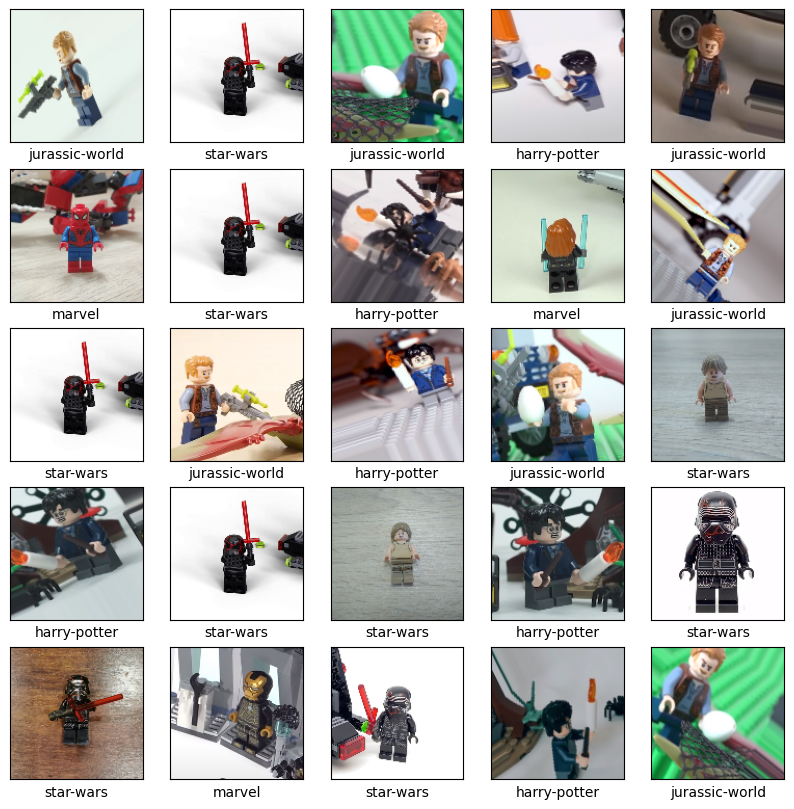

In [ ]:
label_to_index = {label: index for index, label in enumerate(class_names)}

# Select 25 random image indices
random_indices = np.random.choice(len(train_images), size=25, replace=False)

plt.figure(figsize=(10,10))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_index])  # Use the random_index here
    label_index = label_to_index[train_labels[random_index]]  # And here
    plt.xlabel(class_names[label_index])
plt.show()


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
#from tensorflow.keras.applications import VGG16
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#for layer in base_model.layers:
#    layer.trainable = False


#from tensorflow.keras.applications.resnet50 import ResNet50

#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#for layer in base_model.layers:
#    layer.trainable = False


# Load the MobileNetV2 model without the top classification layer
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model

num_layers_to_unfreeze = 5

for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True


#for layer in base_model.layers:
#    layer.trainable = False


In [ ]:
import visualkeras

In [ ]:
num_classes = len(class_names)

model = models.Sequential()

# Add the pre-trained base model
model.add(base_model)

# Continue with your custom layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Let's visualize the model
#visualkeras.layered_view(model,legend=True)


In [ ]:
#model = models.Sequential()

# Begin with a Conv2D layer
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))  # Adding dropout for regularization

#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))  # Adding dropout for regularization

#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))  # Adding dropout for regularization

#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))  # Adding dropout for regularization
#model.add(layers.Dense(num_classes, activation='softmax'))

Let's display the architecture of your model so far:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2621568   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                

### Compile and train the model

In [ ]:
# Define your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_encoded , epochs=15,
                    validation_data=(test_images, test_labels_encoded))

Epoch 1/15
5/5 [==============================] - 35s 315ms/step - loss: 2.4084 - accuracy: 0.9926 - val_loss: 3.9578 - val_accuracy: 0.4528
Epoch 2/15
5/5 [==============================] - 0s 76ms/step - loss: 2.2852 - accuracy: 1.0000 - val_loss: 4.0523 - val_accuracy: 0.4906
Epoch 3/15
5/5 [==============================] - 0s 71ms/step - loss: 2.2073 - accuracy: 0.9926 - val_loss: 4.1887 - val_accuracy: 0.5849
Epoch 4/15
5/5 [==============================] - 0s 63ms/step - loss: 2.1126 - accuracy: 1.0000 - val_loss: 4.2798 - val_accuracy: 0.6038
Epoch 5/15
5/5 [==============================] - 0s 62ms/step - loss: 2.0431 - accuracy: 1.0000 - val_loss: 4.3330 - val_accuracy: 0.6038
Epoch 6/15
5/5 [==============================] - 0s 72ms/step - loss: 1.9685 - accuracy: 1.0000 - val_loss: 4.3615 - val_accuracy: 0.5849
Epoch 7/15
5/5 [==============================] - 0s 70ms/step - loss: 1.9042 - accuracy: 1.0000 - val_loss: 4.3721 - val_accuracy: 0.5660
Epoch 8/15
5/5 [=========

### Evaluate the model

2/2 - 0s - loss: 3.6167 - accuracy: 0.6038 - 137ms/epoch - 69ms/step


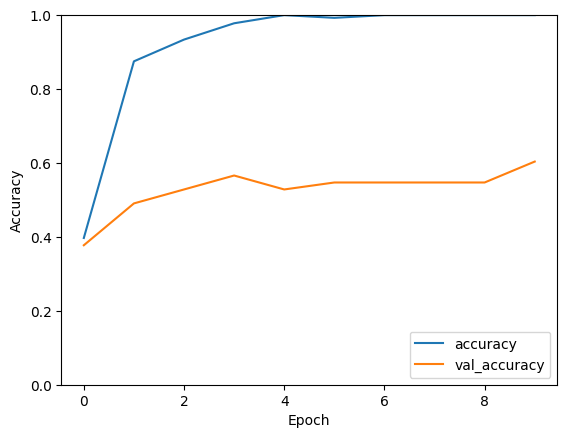

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels_encoded, verbose=2)

In [ ]:
print(test_acc)

0.6037735939025879


2/2 [==============================] - 1s 18ms/step


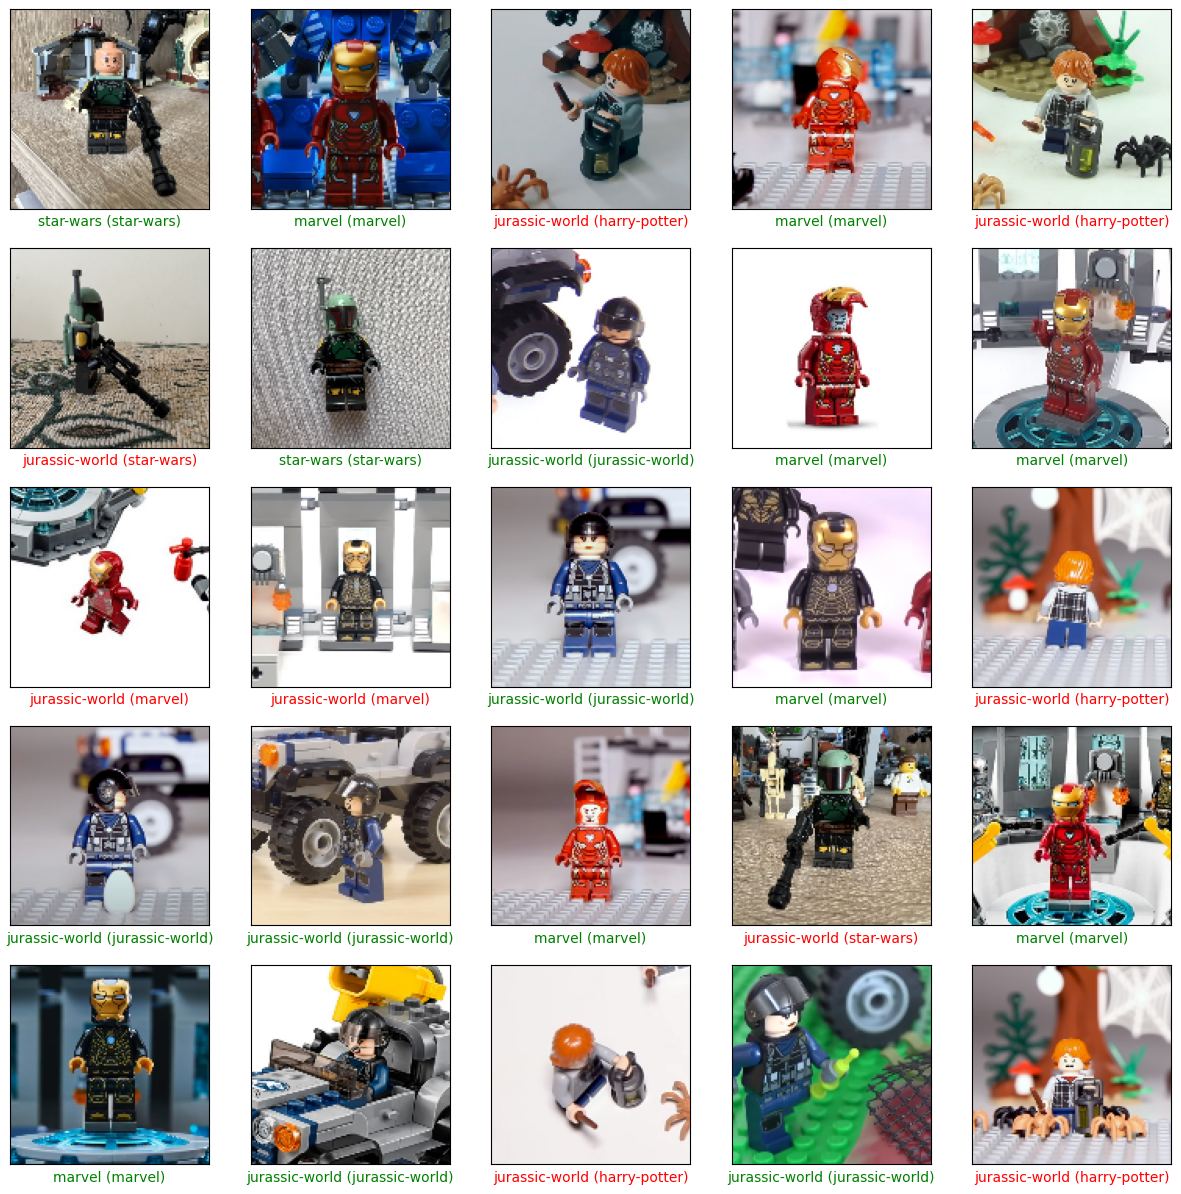

In [ ]:
# First, get predictions for validation images
predicted_scores = model.predict(test_images)  # Note: We are using test_images as you named your validation set 'test'
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = {index: label for label, index in label_to_index.items()}

# Select 25 random image indices from the validation set
random_indices = np.random.choice(len(test_images), size=25, replace=False)

plt.figure(figsize=(15,15))
for idx, random_index in enumerate(random_indices):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[random_index])
    predicted_label = index_to_label[predicted_labels[random_index]]
    true_label = test_labels[random_index]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f"{predicted_label} ({true_label})", color=color)  # Plotting predicted label (true label)
plt.show()


In [ ]:
def load_images_from_directory(directory, image_size):
    data = []
    image_names = []

    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
#        print(f"Processing: {image_path}")  # Add this to know which image is being processed

        if os.path.isfile(image_path):
            try:
                # Load and preprocess the image
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
                image_array = tf.keras.preprocessing.image.img_to_array(image)
                image_array = image_array / 255.0  # Normalize
                data.append(image_array)
                image_names.append(image_name)  # store image names for reference
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return np.array(data), image_names


In [ ]:
new_directory = "/content/drive/MyDrive/PAM_MachineLearning/Lego/validation"
new_images, image_names = load_images_from_directory(new_directory, image_size=(128, 128))

In [ ]:
# Predict using your trained model
predictions = model.predict(new_images)
predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]

#for img_name, pred_label in zip(image_names, predicted_labels):
#    print(f"Image: {img_name}, Predicted Label: {pred_label}")

15/15 [==============================] - 1s 52ms/step


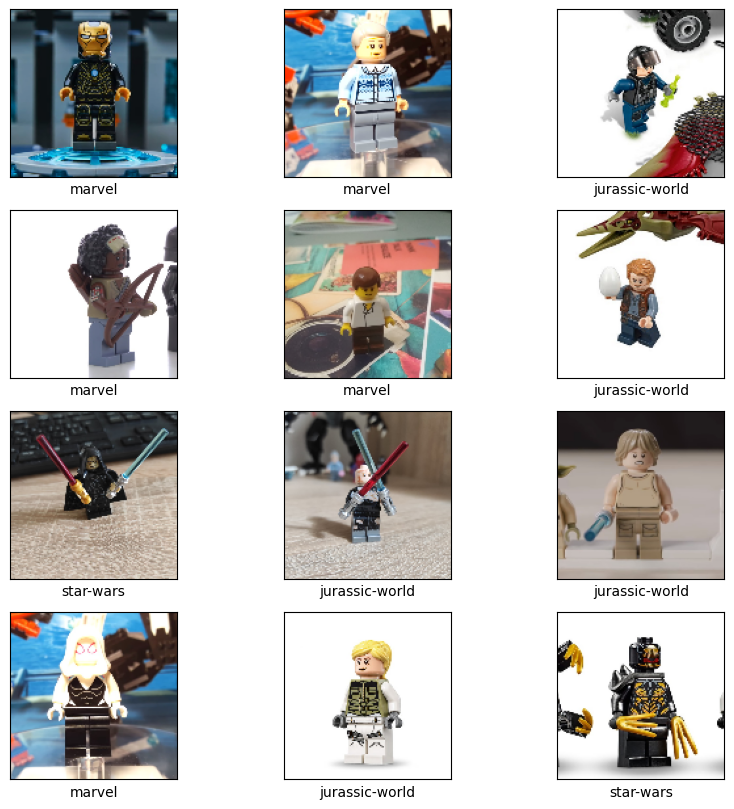

In [ ]:
# Select 25 random image indices from the validation set
rand_idx = np.random.choice(len(new_images), size=12, replace=False)

plt.figure(figsize=(10,10))
for idx, rand_idx in enumerate(rand_idx):
    plt.subplot(4,3,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(new_images[rand_idx])
    predicted_label = predicted_labels[rand_idx]
    plt.xlabel(predicted_labels[idx])
plt.show()

In [ ]:
import csv
pred = pd.DataFrame({'Prediction': predicted_labels})
pred.head()

,Prediction
0,Bus
1,Car
2,Car
3,Car
4,Truck


In [ ]:
pred.to_csv('Predictions.csv', index= false)

In [ ]:
from collections import Counter
class_distribution = Counter(predicted_labels)

total_predictions = len(predicted_labels)

In [ ]:
print("Class Distribution:\n")
for label, count in class_distribution.items():
    fraction = count / total_predictions
    print(f"Class: {label}, Count: {count}, Fraction: {fraction:.2%}")

Class Distribution:

Class: Bus, Count: 37, Fraction: 7.76%
Class: Car, Count: 116, Fraction: 24.32%
Class: Truck, Count: 276, Fraction: 57.86%
Class: motorcycle, Count: 48, Fraction: 10.06%
